<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_04/binary_classification_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification example - classifying movie reviews from the IMDB dataset


Based on: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter04_getting-started-with-neural-networks.ipynb

IMDB Dataset is a dataset for binary sentiment classification (positive or negative reviews). It contains a set of 25,000 highly polar movie reviews for training and 25,000 for testing. 
http://ai.stanford.edu/~amaas/data/sentiment/
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews




In [149]:
# Load the IMDB dataset
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10_000)



Observe the data:

In [150]:
import numpy as np

# 25000 training samples - movie reviews.
print(train_data.shape, train_labels.shape)

# 25000 testing samples - movie reviews.
print(test_data.shape, test_labels.shape)

# 2 categories: positive / negative sentinent
print(train_labels[:10])

print(train_data[1])

# 10000 most common words
dimension = max([max(sequence) for sequence in train_data])+1
print(dimension)

# Distribution of training and testing labels
print("Training Label distribution:", np.bincount(train_labels))
print("Testing Label distribution:", np.bincount(test_labels))



(25000,) (25000,)
(25000,) (25000,)
[1 0 0 1 0 0 1 0 1 0]
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]
10000
Training Label distribution: [12500 12500]
Testing Label distribution: [12500 12500]


Example of a review in the training data:

In [151]:
# Get the word index from the IMDB dataset.
# This is a dictionary mapping words to integers.
word_index = imdb.get_word_index()

# Create a reverse word index, mapping integers back to words.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decode the first review in the training data.
# Subtract 3 from each index to account for special tokens (padding, start of sequence, unknown).
# Replace any unknown words with '?'.
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

# Print the decoded review.
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

# Preprocess the data

In [152]:
# 1. Vectorize the data
def vectorize_sequences(sequences):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

x_train_ext = vectorize_sequences(train_data)  # Vectorize training data
x_test = vectorize_sequences(test_data)    # Vectorize testing data

y_train_ext = np.asarray(train_labels).astype('float32')  # Vectorize training labels
y_test = np.asarray(test_labels).astype('float32')    # Vectorize testing labels


# 2. Split the training data into training and validation sets
# The validation set is used to monitor the performance of the model during training and prevent overfitting.
x_val = x_train_ext[:10000]
x_train = x_train_ext[10000:]
y_val = y_train_ext[:10000]
y_train = y_train_ext[10000:]
y_train = y_train.reshape(-1, 1)  # Reshape to match output shape
y_val = y_val.reshape(-1, 1)      # Reshape to match output shape
y_test = y_test.reshape(-1, 1)      # Reshape to match output shape


print(x_train[0], x_train.shape, y_train[0])

[0. 1. 1. ... 0. 0. 0.] (15000, 10000) [0.]


# Define and train the model

### MLP model for binary classification:
- 'sigmoid' activation function in the output layer 
- 'relu' or 'tanh' in the hidden layers
- BinaryCrossentropy (or MSE) loss function + BinaryAccuracy metrics (https://keras.io/api/metrics)

In [153]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "imdb_mlp_"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_imdb/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################


# define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(shape=(10000,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # output layer
])

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
              loss= keras.losses.BinaryCrossentropy(),
              metrics= [keras.metrics.BinaryAccuracy()])


num_epochs = 20
batch_size = 512

# Train the model
history = model.fit(x_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

# Save the model
model_dir = "./models/"

# Ensure the directory exists
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# Create a unique model name using the current date and time
model_name = model_dir + model_datetime_name + ".keras"
# Save the model with the generated name
model.save(model_name)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,305 (626.19 KB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - binary_accuracy: 0.6699 - loss: 0.6241 - val_binary_accuracy: 0.8614 - val_loss: 0.3875
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.8936 - loss: 0.3152 - val_binary_accuracy: 0.8869 - val_loss: 0.2882
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - binary_accuracy: 0.9350 - loss: 0.1953 - val_binary_accuracy: 0.8847 - val_loss: 0.2836
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - binary_accuracy: 0.9572 - loss: 0.1407 - val_binary_accuracy: 0.8856 - val_loss: 0.2893
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - binary_accuracy: 0.9710 - loss: 0.1075 - val_binary_accuracy: 0.8820 - val_loss: 0.3091
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.9843 - loss: 0.0735 - val_binary_accuracy: 0.8795 - val_loss: 0.3359
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.9893 - loss: 0.0566 - val_binary_accuracy: 0.8781 - val_loss: 0.3652
Epoch 8/20
30

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])


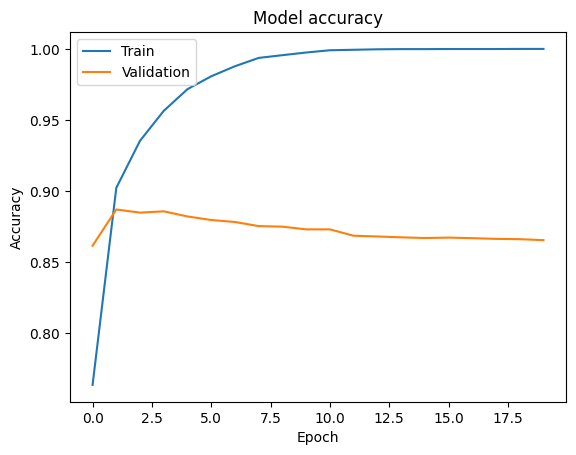

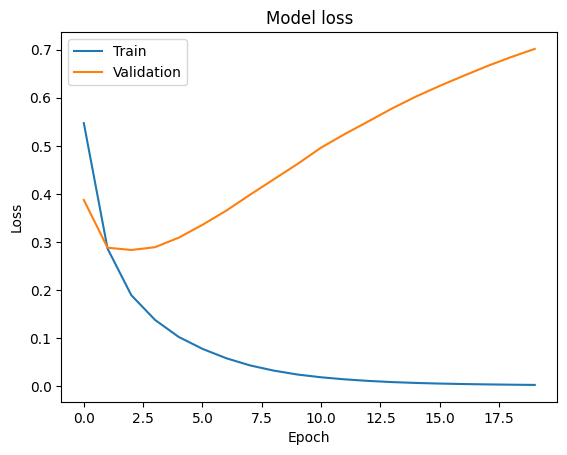

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8672 - loss: 0.6928
Validation accuracy: 0.8652999997138977 
Test loss: 0.7013603448867798
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8517 - loss: 0.7724
Test accuracy: 0.8538399934768677 
Test loss: 0.7566609978675842


In [154]:
# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())


# Plot training & validation accuracy values
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the validation set
test_loss, test_acc = model.evaluate(x_val, y_val)
print('Validation accuracy:', test_acc, '\nTest loss:', test_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

## Evaluate the model and make predictions on new data

In [155]:

# Get predicted probabilities for the test set
y_pred_probs = model.predict(x_test)

# Convert probabilities to class predictions (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)

# Find the indices of misclassified samples
misclassified_indices = np.where(y_pred != y_test)[0]

# Print the number of misclassified samples
print("Number of misclassified samples:", len(misclassified_indices))

# Print examples of misclassified samples (e.g., first 5)
num_examples_to_show = 5
for i in range(min(num_examples_to_show, len(misclassified_indices))):
    index = misclassified_indices[i]
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[index]])
    print(f"\nMisclassified Sample {i+1}:")
    print("Predicted Class:", y_pred[index][0])
    print("True Class:", y_test[index][0])
    print("Review:", decoded_review)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Number of misclassified samples: 3654

Misclassified Sample 1:
Predicted Class: 1
True Class: 0.0
Review: ? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are ? involved with 

# Summary

1. For binary classification, the loss function BinaryCrossentropy is used (though MSE can also be used), and the metric is BinaryAccuracy. A sigmoid activation function is chosen for the output layer.
2. If input vectors have different lengths, they need to be adjusted to have the same length.
3. Word index is the simplest way to encode texts (but there are better approaches like TF-IDF, Word Embeddings, etc.).
4. To evaluate how well the model is learning and generalizing, a validation dataset is used.


# Excersises
1. **Change the number of epochs** to avoid overtraining. Compare the errors on the validation and the test sets.
2. **Implement early stopping** to avoid overtraining. Compare the errors.
3. **Change the number of neurons or layers.** See how this affects the accuracy of the model and the learning curves.
You can also experiment with different **activation functions**
in the hidden layers.
4. **Change the loss function**.
Try using the mse (mean squared error) loss function and compare the results.


In [156]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [157]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_imdb --reload_interval=1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6010 (pid 17488), started 0:08:01 ago. (Use '!kill 17488' to kill it.)